In [2]:
import os
import torch
import config
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import cv2
from sklearn.metrics import confusion_matrix, classification_report

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CLASS_LABELS = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

### 1. Load Dataset

In [3]:
class FER2013(Dataset):
    def __init__(self, ttv, transform=None):
        '''
        Arguments:
            ttv (string): 'train', 'val', or 'test'
            transform (callable, optional): Optional transform to be applied on image
        '''
        if ttv not in ['train', 'val', 'test']:
            raise ValueError(f"ttv={ttv} is not 'train', 'val', 'test'") 
        self.data = os.path.join(config.DATA_PATH, ttv)
        self.labels = np.load(os.path.join(config.ANNOTATIONS_PATH, ttv + '_labels.npy'))    
        self.transform = transform
        self.ttv = ttv
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image_name = self.ttv + '_' + str(idx) + '.jpg'
        image = cv2.imread(os.path.join(self.data, image_name))
        if self.transform:
            image = self.transform(image=image)['image']
        label = torch.tensor(self.labels[idx], dtype=torch.uint8)
        return image, label
    
    def get_labels(self):
        return self.labels

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
base_tf = A.Compose([
    ToTensorV2(),
])

train_dataset = FER2013('train', base_tf)
valid_dataset = FER2013('val', base_tf)
test_dataset = FER2013('test', base_tf)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

### 2. Class Weights

#### 2a. Plot Dataset 

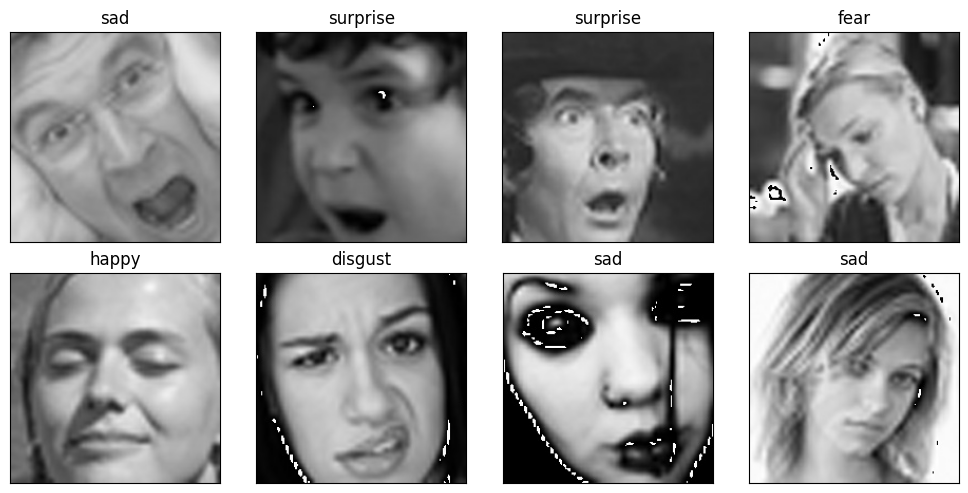

In [6]:
def plot_dataset(loader):
    ncols = loader.batch_size // 2
    nrows = loader.batch_size // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})
    class_map = {
        0: 'angry',
        1: 'disgust',
        2: 'fear', 
        3:'happy',
        4: 'sad',
        5: 'surprise',
        6: 'neutral'
    }
    for images, labels in loader:
        for i, ax in enumerate(axes.flat):
            image = images[i].cpu().numpy().transpose(1, 2, 0)
            label = int(labels[i].cpu())
            
            ax.imshow(image, cmap='gray')
            
            ax.set_title(f'{class_map[label]}')
        break

    plt.tight_layout()
    plt.show()

plot_dataset(train_loader)

#### 2b. Plot Class Distribution

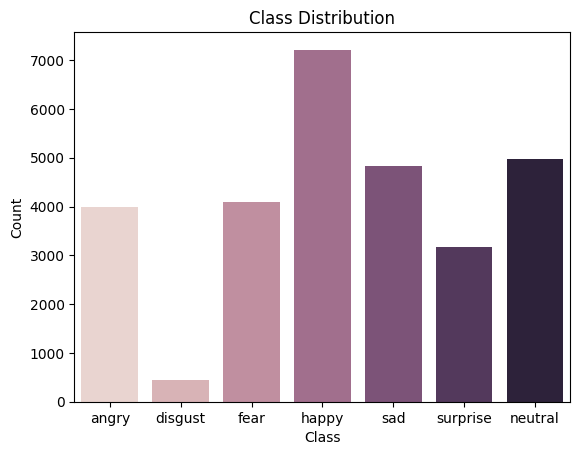

In [12]:
def plot_class_distribution(dataset):
    plot = sns.countplot(x=dataset.get_labels(), hue=dataset.get_labels(), legend=False)
    plot.set_title('Class Distribution')
    plot.set_xlabel('Class')
    plot.set_ylabel('Count')
    plot.set_xticks(range(len(CLASS_LABELS)))
    plot.set_xticklabels(CLASS_LABELS)
    
plot_class_distribution(train_dataset)

#### 2c. Create Class Weights for Imbalanced Data

In [89]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights of dataset
def get_class_weights(dataset):
    labels = dataset.get_labels()
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    return torch.tensor(class_weights).float().to(DEVICE)

train_class_weights = get_class_weights(train_dataset) 
print(train_class_weights)

tensor([1.0266, 9.4066, 1.0010, 0.5684, 0.8491, 1.2934, 0.8260],
       device='cuda:0')


### 3. Train and Evaluate Functions

In [49]:
def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

        accuracy = correct_predictions / total_samples    
        average_loss = running_loss / len(loader)
        
        print(f'validation_loss: {average_loss:.4f} - valid_accuracy: {accuracy:.4f}')
            
    return accuracy, average_loss, y_true, y_pred

In [50]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0.1):
        '''
        Arguments:
            patience (int): number of times to allow for no improvement before stopping the execution
            min_delta (float): minimum change counted as an improvement
        '''
        self.patience = patience 
        self.min_delta = min_delta
        self.counter = 0 # internal counter
        self.min_validation_loss = np.inf

    # Return True when validation loss is not decreased by `min_delta` `patience` times 
    def early_stop(self, validation_loss):
        if ((validation_loss + self.min_delta) < self.min_validation_loss):
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif ((validation_loss + self.min_delta) > self.min_validation_loss):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [83]:
def train_model(model, optimizer, train_loader, valid_loader, criterion, num_epochs, prefix):
    model.to(DEVICE)
    best_accuracy_train = 0
    best_accuracy_val = 0
    train_acc = []
    train_loss = []
    valid_acc = []
    valid_loss = []
    early_stopper = EarlyStopper(patience=10, min_delta=0.5)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        loop = tqdm(train_loader, leave=False)
        for inputs, labels in loop:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            loop.set_description(f'Epoch [{epoch + 1}/{num_epochs}]')
            
        train_accuracy = correct_predictions / total_samples    
        average_loss = running_loss / len(train_loader)
        
        print('.' * 64)
        print(f"--- Epoch {epoch + 1}/{num_epochs} ---")
        print(f'train_loss: {average_loss:.4f} - train_accuracy: {train_accuracy:.4f}')
        
        if train_accuracy > best_accuracy_train:
            best_accuracy_train = train_accuracy
            torch.save(model.state_dict(), f'./models/{prefix}_best_train.pth')
            
        valid_accuracy, val_loss, y_true, y_pred = evaluate_model(model, valid_loader, criterion)
        
        if valid_accuracy > best_accuracy_val:
            best_accuracy_val = valid_accuracy
            torch.save(model.state_dict(), f'./models/{prefix}_best_valid.pth')

        train_acc.append(train_accuracy)
        train_loss.append(average_loss)
        valid_acc.append(valid_accuracy)
        valid_loss.append(val_loss)
        
        if early_stopper.early_stop(val_loss):
            print(f'Stopping early at Epoch {epoch + 1}, validation loss failed to decrease')
            break

    return {
        'train_accuracy': train_acc,
        'train_loss': train_loss,
        'valid_accuracy': valid_acc,
        'valid_loss': valid_loss,
        'y_true': y_true,
        'y_pred': y_pred
    }

### 4. Train Model

In [90]:
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import torch.optim as optim

weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
# Edit final model classifier layer  
model.fc = nn.Linear(in_features=2048, out_features=len(np.unique(train_dataset.get_labels())), bias=True)
criterion = nn.CrossEntropyLoss(weight=train_class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [91]:
results = train_model(model, optimizer, train_loader, valid_loader, criterion, 10, 'ResNet50')

................................................................
--- Epoch 1/10 ---
train_loss: 1.9134 - train_accuracy: 0.2065
validation_loss: 1.9864 - valid_accuracy: 0.2561


................................................................
--- Epoch 2/10 ---
train_loss: 1.9145 - train_accuracy: 0.2069
validation_loss: 1.9896 - valid_accuracy: 0.1524


................................................................
--- Epoch 3/10 ---
train_loss: 1.8928 - train_accuracy: 0.2218
validation_loss: 1.8689 - valid_accuracy: 0.2744


................................................................
--- Epoch 4/10 ---
train_loss: 1.8230 - train_accuracy: 0.2674
validation_loss: 1.7530 - valid_accuracy: 0.3040


................................................................
--- Epoch 5/10 ---
train_loss: 1.7159 - train_accuracy: 0.3372
validation_loss: 1.6375 - valid_accuracy: 0.4057


................................................................
--- Epoch 6/10 ---
train_loss: 1.6068 - train_accuracy: 0.4022
validation_loss: 1.5859 - valid_accuracy: 0.4302


................................................................
--- Epoch 7/10 ---
train_loss: 1.5357 - train_accuracy: 0.4314
validation_loss: 1.5548 - valid_accuracy: 0.4143


................................................................
--- Epoch 8/10 ---
train_loss: 1.4723 - train_accuracy: 0.4519
validation_loss: 1.4997 - valid_accuracy: 0.4572


................................................................
--- Epoch 9/10 ---
train_loss: 1.4278 - train_accuracy: 0.4703
validation_loss: 1.5524 - valid_accuracy: 0.4316


................................................................
--- Epoch 10/10 ---
train_loss: 1.3910 - train_accuracy: 0.4797
validation_loss: 1.5207 - valid_accuracy: 0.4374


### 5. Model Evaluation

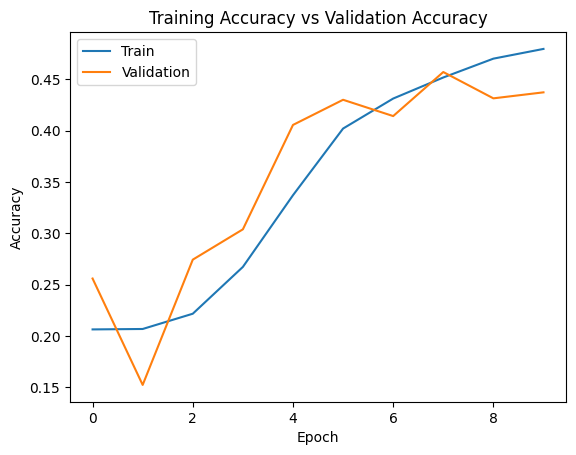

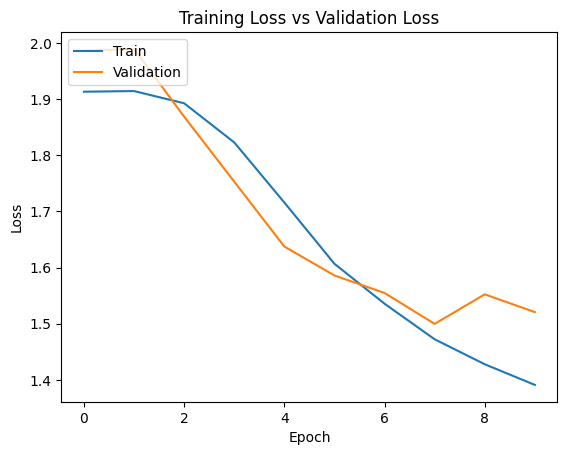

In [92]:
def plot_training_history(results):
    plt.figure()
    plt.plot(results['train_accuracy'])
    plt.plot(results['valid_accuracy'])
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.figure()
    plt.plot(results['train_loss'])
    plt.plot(results['valid_loss'])
    plt.title('Training Loss vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()
plot_training_history(results)

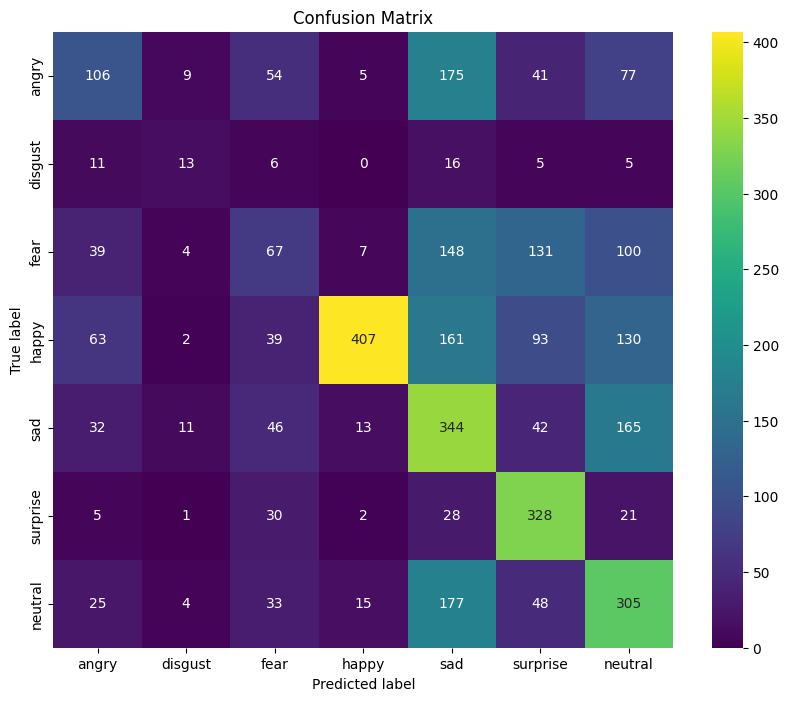

In [93]:
def plot_confusion_matrix(results):
    cm = confusion_matrix(results['y_true'], results['y_pred'])
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
plot_confusion_matrix(results)

In [94]:
def display_classification_report(results):
    print('=== Classification Report ===')
    print(classification_report(results['y_true'], results['y_pred'], target_names=CLASS_LABELS, digits=4))

display_classification_report(results)

=== Classification Report ===
              precision    recall  f1-score   support

       angry     0.3772    0.2270    0.2834       467
     disgust     0.2955    0.2321    0.2600        56
        fear     0.2436    0.1351    0.1738       496
       happy     0.9065    0.4547    0.6057       895
         sad     0.3279    0.5268    0.4042       653
    surprise     0.4767    0.7904    0.5947       415
     neutral     0.3798    0.5025    0.4326       607

    accuracy                         0.4374      3589
   macro avg     0.4296    0.4098    0.3935      3589
weighted avg     0.4924    0.4374    0.4315      3589



### 6. Model Predictions

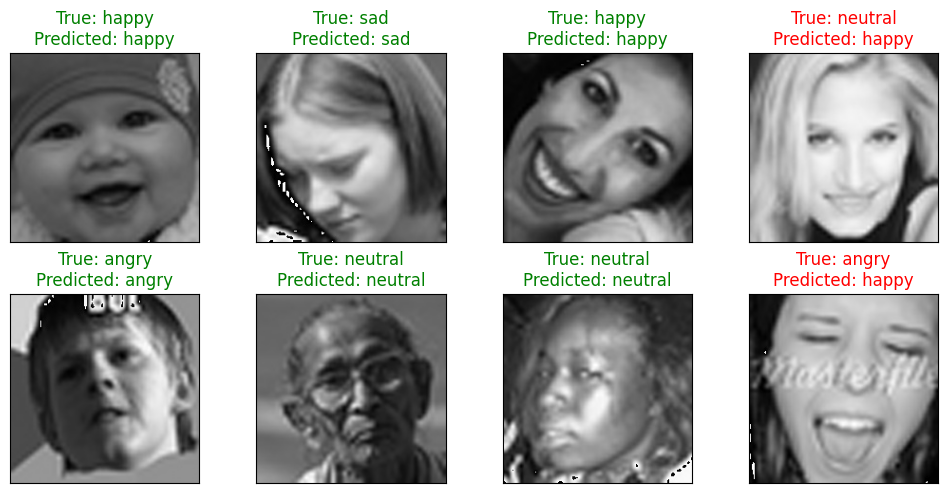

In [102]:
# Load model
MODEL_PATH = './models/ResNet50_valid.pth'
weights = ResNet50_Weights.DEFAULT
model = models.resnet50(weights=weights).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH))

def plot_predictions(model, loader):
    model.eval()
    ncols = loader.batch_size // 2
    nrows = loader.batch_size // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})
    class_map = {
        0: 'angry',
        1: 'disgust',
        2: 'fear', 
        3:'happy',
        4: 'sad',
        5: 'surprise',
        6: 'neutral'
    }
    # Make prediction on test set
    with torch.no_grad():
        for inputs, true_labels in loader:
            inputs, true_labels = inputs.to(DEVICE), true_labels.to(DEVICE)
            outputs = model(inputs.float())
            _, predicted = torch.max(outputs, 1)

            for i, ax in enumerate(axes.flat):
                image = inputs[i].cpu().numpy().transpose(1, 2, 0)
                true_label = int(true_labels[i].cpu())
                pred_label = int(predicted[i].cpu())
                
                ax.imshow(image, cmap='gray')
                
                color = 'green' if true_label == pred_label else 'red'
                ax.set_title(f'True: {class_map[true_label]}\nPredicted: {class_map[pred_label]}', color=color)
            break # break early to test only 1 batch

    plt.tight_layout()
    plt.show()

plot_predictions(model, train_loader)

### Areas for Improvements
TODO: 
- ~~Implement early stopping (5-10 epochs)~~
- ~~Computing class weights to scale imbalanced data~~
- Baseline non-occlusion-aware-like data augmentation and pre-processing
- Transfer learning e.g. using ImageNet as base model
- Trying different models, optimizers and criterion
- Train for 30 epochs
- Look at CompreFace for face detection
- NCI access
- Create benchmark with other papers using FER-2013
